In [12]:
import nlp
import sentencepiece as spm
from tqdm import tqdm
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sps

from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset as TorchDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

from models.seq2seq_generator import Seq2Seq, Encoder, Decoder
from models.lstm_generator import LSTMGenerator
from models.cnn_discriminator import CNNDiscriminator2
from models.cnn_discriminator3 import CNNDiscriminator3
from models.rollout import ROLLOUT
import models

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

import spacy
from nltk.corpus import stopwords

sns.set_style('whitegrid')

stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [11]:
import importlib
importlib.reload(models.cnn_discriminator3)
importlib.reload(models.seq2seq_generator)

<module 'models.seq2seq_generator' from '/home/amutolapov/topical_summarization/gans/models/seq2seq_generator.py'>

### 1. load data

In [3]:
%%time
train_dataset = nlp.load_dataset("cnn_dailymail", "3.0.0", split="train")
val_dataset = nlp.load_dataset("cnn_dailymail", "3.0.0", split="validation")
test_dataset = nlp.load_dataset("cnn_dailymail", "3.0.0", split="test")

CPU times: user 177 ms, sys: 4.61 ms, total: 182 ms
Wall time: 3.84 s


In [4]:
%%time
train_articles = [item['article'] for item in train_dataset]
train_highlights = [item['highlights'] for item in train_dataset]
val_articles = [item['article'] for item in val_dataset]
val_highlights = [item['highlights'] for item in val_dataset]

NameError: name 'train_dataset' is not defined

In [24]:
def process_str(s):
    s = s.lower()
    s = re.sub("[^0-9a-zA-Z ]", " ", s)
    return s

news = pd.read_csv('data/news_summary.csv')
news.headlines = [process_str(s) for s in news.headlines]
news.text = [process_str(s) for s in news.text]
X_train, X_test = train_test_split(news, test_size=0.3,
                                   random_state=42)

train_articles = X_train.text.values
train_highlights = X_train.headlines.values
val_articles = X_test.text.values
val_highlights = X_test.headlines.values

In [25]:
'''
%%time
with open('data/news_texts.txt', 'a') as f:
    for article in tqdm(train_articles):
        f.write(article + '\n')
    for highlight in tqdm(train_highlights):
        f.write(highlight + '\n')
    for article in tqdm(val_articles):
        f.write(article + '\n')
    for highlight in tqdm(val_highlights):
        f.write(highlight + '\n')
'''

"\n%%time\nwith open('data/news_texts.txt', 'a') as f:\n    for article in tqdm(train_articles):\n        f.write(article + '\n')\n    for highlight in tqdm(train_highlights):\n        f.write(highlight + '\n')\n    for article in tqdm(val_articles):\n        f.write(article + '\n')\n    for highlight in tqdm(val_highlights):\n        f.write(highlight + '\n')\n"

In [26]:
'''
%%time
spm.SentencePieceTrainer.train(input='data/news_texts.txt',
                               model_prefix='news10k',
                               vocab_size=10000,
                               pad_id=0,
                               bos_id=1,
                               eos_id=2,
                               unk_id=3)
'''

"\n%%time\nspm.SentencePieceTrainer.train(input='data/news_texts.txt',\n                               model_prefix='news10k',\n                               vocab_size=10000,\n                               pad_id=0,\n                               bos_id=1,\n                               eos_id=2,\n                               unk_id=3)\n"

### 2. lda

In [ ]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        
articles_words = list(sent_to_words(train_articles))
highlights_words = list(sent_to_words(train_highlights))

In [ ]:
%%time
bigram = gensim.models.Phrases(articles_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[articles_words], threshold=100)  

bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

print(trigram_mod[bigram_mod[articles_words[0]]])

In [ ]:
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
%%time

# Remove Stop Words
data_words_nostops = remove_stopwords(articles_words)
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])
# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
print(data_lemmatized[:1])

In [28]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)
# Create Corpus
texts = data_lemmatized
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 2), (3, 2), (4, 2), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1)]]


In [29]:
id2word[0]

'control'

In [30]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('control', 1),
  ('fly', 1),
  ('helicopter', 2),
  ('indian', 2),
  ('line', 2),
  ('report', 1),
  ('reportedly', 1),
  ('return', 1),
  ('say', 1),
  ('shoot', 1),
  ('spokesman', 1),
  ('territory', 1),
  ('try', 1),
  ('violate', 1)]]

In [32]:
%%time
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=10, 
                                            random_state=100,
                                            update_every=1,
                                            chunksize=100,
                                            passes=10,
                                            alpha='auto',
                                            per_word_topics=True)

CPU times: user 3min 35s, sys: 592 ms, total: 3min 36s
Wall time: 3min 36s


In [33]:
lda_model.print_topics()

[(0,
  '0.122*"year" + 0.046*"woman" + 0.045*"old" + 0.036*"man" + 0.034*"last" + 0.025*"month" + 0.021*"leader" + 0.020*"video" + 0.016*"post" + 0.014*"lose"'),
 (1,
  '0.063*"police" + 0.034*"official" + 0.030*"find" + 0.029*"follow" + 0.029*"case" + 0.026*"allegedly" + 0.019*"due" + 0.018*"incident" + 0.018*"allege" + 0.016*"charge"'),
 (2,
  '0.037*"tweet" + 0.035*"user" + 0.034*"new" + 0.034*"announce" + 0.026*"launch" + 0.022*"start" + 0.021*"move" + 0.015*"datum" + 0.014*"law" + 0.014*"create"'),
 (3,
  '0.049*"arrest" + 0.046*"actor" + 0.040*"release" + 0.029*"trump" + 0.022*"demand" + 0.022*"raise" + 0.020*"actress" + 0.020*"fire" + 0.016*"area" + 0.015*"award"'),
 (4,
  '0.035*"could" + 0.032*"hold" + 0.026*"service" + 0.023*"ban" + 0.023*"employee" + 0.018*"build" + 0.017*"suggest" + 0.017*"study" + 0.015*"stand" + 0.014*"ahead"'),
 (5,
  '0.096*"say" + 0.035*"add" + 0.021*"also" + 0.018*"government" + 0.017*"report" + 0.017*"make" + 0.017*"people" + 0.014*"claim" + 0.014*"c

In [41]:
lda_model.get_document_topics(corpus[200])

[(0, 0.07709452),
 (1, 0.09352767),
 (2, 0.03485591),
 (3, 0.028689157),
 (4, 0.025051974),
 (5, 0.1638245),
 (6, 0.059819784),
 (7, 0.11712099),
 (8, 0.027248144),
 (9, 0.37276733)]

In [ ]:
def topics_to_ohe()

### 3. dataset and dataloaders

In [28]:
sp = spm.SentencePieceProcessor(model_file='news10k.model')

In [29]:
class Dataset(TorchDataset):
    def __init__(self, articles, highlights):
        self.articles = articles
        self.highlights = highlights

    def __getitem__(self, index):
        article = self.articles[index]
        highlight = self.highlights[index]
        
        return (torch.tensor([1] + sp.encode(article) + [2], dtype=torch.long),
                torch.tensor([1] + sp.encode(highlight) + [2], dtype=torch.long))

    def __len__(self):
        return len(self.articles)

In [30]:
def pad_tensor(vec, length, dim, pad_symbol):
    pad_size = length - vec.shape[dim]
    return torch.cat([vec, torch.zeros(pad_size, dtype=torch.long) + pad_symbol],
                     dim=dim)

class Padder:
    def __init__(self, dim=0, pad_symbol=0):
        self.dim = dim
        self.pad_symbol = pad_symbol
        
    def __call__(self, batch):
        max_article_len = max(map(lambda x: x[0].shape[self.dim], batch))
        max_highlight_len = max(map(lambda x: x[1].shape[self.dim], batch))
        batch = map(lambda x: (pad_tensor(x[0], max_article_len, self.dim, self.pad_symbol), 
                               pad_tensor(x[1], max_highlight_len, self.dim, self.pad_symbol)),
                    batch)
        batch = list(batch)
        xs = torch.stack(list(map(lambda x: x[0], batch)))
        ys = torch.stack(list(map(lambda x: x[1], batch)))
        return xs.permute(1, 0), ys.permute(1, 0)

In [31]:
train_dataset = Dataset(train_articles, train_highlights)
val_dataset = Dataset(val_articles, val_highlights)

train_dataloader = DataLoader(train_dataset, batch_size=128,
                              collate_fn=Padder(), shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=128,
                            collate_fn=Padder(), shuffle=False)

In [32]:
for batch in train_dataloader:
    print(batch[0].size())
    print(batch[1].size())
    break

torch.Size([102, 128])
torch.Size([22, 128])


### 3. model architecture

In [11]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


In [12]:
vocab_size = 10000

In [13]:
writer = SummaryWriter()

In [113]:
INPUT_DIM = vocab_size
OUTPUT_DIM = vocab_size
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 256
N_LAYERS = 3
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

G = Seq2Seq(enc, dec, device).to(device)

In [85]:
emb_dim = 256
hidden_dim = 256
vocab_size = 10000
padding_idx = 0
D = CNNDiscriminator3(embed_dim=emb_dim,
                     vocab_size=vocab_size,
                     num_classes=2,
                     filter_sizes=[2, 3],
                     num_filters=2,
                     padding_idx=padding_idx).to(device)

### 4. generator pretraining

In [27]:
def tensor_to_text(t):
    if len(t.size()) == 3:
        t = t.permute(1, 0, 2)
        t = F.softmax(t, dim=2)
        tokens = torch.argmax(t, dim=2).detach().cpu().numpy().tolist()
        tokens = list(map(lambda x: [int(c) for c in x], tokens))
        return sp.decode(tokens)
    elif len(t.size()) == 2:
        tokens = t.permute(1, 0).detach().cpu().numpy().tolist()
        tokens = list(map(lambda x: [int(c) for c in x], tokens))
        return sp.decode(tokens)

In [7]:
len(train_dataloader)

NameError: name 'train_dataloader' is not defined

In [19]:
criterion = nn.CrossEntropyLoss(ignore_index=0)
lr = 1e-3
opt = torch.optim.Adam(G.parameters(), lr=lr)
n_epochs = 30

epoch_losses = []
val_losses = []
iter_num = -1

In [20]:
for epoch_idx in range(n_epochs):
    G.train()
    total_loss = 0.
    for batch_idx, data_input in tqdm(enumerate(train_dataloader), position=0, leave=True):
        article = data_input[0].to(device)
        highlight = data_input[1].to(device)
        opt.zero_grad()
        out = G(article, highlight, teacher_forcing_ratio=0.5)
        loss = criterion(out.permute(1, 2, 0), highlight.permute(1, 0))
        loss.backward()
        opt.step()
        total_loss += loss.data.item() * article.size(1)
        iter_num += 1
        writer.add_scalar('Loss/train', loss.data.item(), iter_num)
    
    epoch_losses.append(total_loss / len(train_dataset))
    print(f'epoch {epoch_idx} train loss: {epoch_losses[-1]}')
    
    G.eval()
    total_loss = 0.
    for batch_idx, data_input in tqdm(enumerate(val_dataloader), position=0, leave=True):
        article = data_input[0].to(device)
        highlight = data_input[1].to(device)
        out = G(article, highlight, teacher_forcing_ratio=0.)
        loss = criterion(out.permute(1, 2, 0), highlight.permute(1, 0))
        total_loss += loss.data.item() * article.size(1)

    val_losses.append(total_loss / len(val_dataset))
    print(f'epoch {epoch_idx} val loss: {val_losses[-1]}')
    writer.add_scalar('Loss/val', val_losses[-1], iter_num)
    ind = sps.randint(0, out.size(1)).rvs(size=1)[0]
    print(f'predicted: {tensor_to_text(out)[ind]}')
    print(f'truth: {tensor_to_text(highlight)[ind]}')

539it [01:23,  6.46it/s]
2it [00:00, 15.75it/s]

epoch 0 train loss: 6.917175631240685


231it [00:13, 16.95it/s]
1it [00:00,  6.26it/s]

epoch 0 val loss: 6.879121127625613
predicted: us sssssssss
truth: 18 cpi m men get life term for killing tmc workers in 2010


539it [01:23,  6.43it/s]
2it [00:00, 16.64it/s]

epoch 1 train loss: 6.554846633685175


231it [00:13, 16.95it/s]
1it [00:00,  6.52it/s]

epoch 1 val loss: 6.611574266964873
predicted: kohli ssssssssss
truth: brendon mccullum hit test cricket s fastest ton in his last match


539it [01:23,  6.44it/s]
2it [00:00, 16.38it/s]

epoch 2 train loss: 6.118244276035677


231it [00:13, 16.95it/s]
1it [00:00,  6.35it/s]

epoch 2 val loss: 6.374609159173885
predicted: bjp bjpsss tos tos
truth: cong ncp join hands against bjp for maha council by poll


539it [01:24,  6.41it/s]
2it [00:00, 16.66it/s]

epoch 3 train loss: 5.746087442125593


231it [00:13, 16.85it/s]
1it [00:00,  6.10it/s]

epoch 3 val loss: 6.1354045972103375
predicted: car ssss in space ins in
truth: minor solar flare expected to hit earth today cause auroras


539it [01:24,  6.41it/s]
2it [00:00, 16.75it/s]

epoch 4 train loss: 5.407828332765869


231it [00:13, 16.88it/s]
0it [00:00, ?it/s]

epoch 4 val loss: 5.893783509087213
predicted: google ss s startupsssss
truth: google using ai to improve battery life on android phones


539it [01:24,  6.35it/s]
2it [00:00, 15.64it/s]

epoch 5 train loss: 5.11377748972309


231it [00:13, 16.85it/s]
1it [00:00,  6.78it/s]

epoch 5 val loss: 5.83582568490882
predicted: srikanth ssed for padma shri s highest honoured
truth: kidambi srikanth conferred with padma shri award


539it [01:24,  6.39it/s]
2it [00:00, 16.68it/s]

epoch 6 train loss: 4.849017254123843


231it [00:13, 16.87it/s]
1it [00:00,  6.30it/s]

epoch 6 val loss: 5.783433902409417
predicted: billionaire billionairess billionaires passes away at 81 years
truth: 27 hurun rich list billionaires passed away last year


539it [01:24,  6.39it/s]
2it [00:00, 16.60it/s]

epoch 7 train loss: 4.625793932096191


231it [00:13, 16.87it/s]
1it [00:00,  6.26it/s]

epoch 7 val loss: 5.729732575049419
predicted: waseded the great for hindi akshay on big b
truth: received best compliment from dilip kumar for black big b


539it [01:24,  6.38it/s]
2it [00:00, 16.65it/s]

epoch 8 train loss: 4.423260250601065


231it [00:13, 16.88it/s]
1it [00:00,  6.16it/s]

epoch 8 val loss: 5.708525631551412
predicted: first look poster of sushant kriti kriti raab raab s raabta
truth: first look poster of sushant kriti s raabta unveiled


539it [01:25,  6.34it/s]
2it [00:00, 16.03it/s]

epoch 9 train loss: 4.259697204793649


231it [00:13, 16.83it/s]
1it [00:00,  6.59it/s]

epoch 9 val loss: 5.713098514096604
predicted: bengaluru policess video on video without helmet
truth: b luru police ask people to wear helmets share 10 secs challenge


539it [01:24,  6.40it/s]
2it [00:00, 16.22it/s]

epoch 10 train loss: 4.110545614399838


231it [00:13, 16.80it/s]
1it [00:00,  6.78it/s]

epoch 10 val loss: 5.799165960597271
predicted: i got greatest inspiration for a from s karunanidhi s
truth: received best compliment from dilip kumar for black big b


539it [01:24,  6.40it/s]
2it [00:00, 16.49it/s]

epoch 11 train loss: 3.982742372705546


231it [00:13, 16.74it/s]
1it [00:00,  6.40it/s]

epoch 11 val loss: 5.8029957451611525
predicted: i have been in 37 casessssss shivrajhan
truth: daughters should be taught about good bad touch mp cm


539it [01:24,  6.39it/s]
2it [00:00, 15.58it/s]

epoch 12 train loss: 3.8663296705062105


231it [00:13, 16.65it/s]
1it [00:00,  6.75it/s]

epoch 12 val loss: 5.752110923403853
predicted: sonam kapoor wears vinta 000ss in her film film cannes film cannes cannes
truth: sonam wears custom made jewellery by sister rhea at cannes


539it [01:24,  6.37it/s]
2it [00:00, 16.51it/s]

epoch 13 train loss: 3.7234113777417615


231it [00:13, 16.73it/s]
1it [00:00,  6.84it/s]

epoch 13 val loss: 5.790452055877626
predicted: farmers smuggle milkssssss roads
truth: farmers dump vegetables spill milk on roads during protest


539it [01:24,  6.39it/s]
2it [00:00, 16.06it/s]

epoch 14 train loss: 3.654411861539302


231it [00:13, 16.72it/s]
1it [00:00,  6.20it/s]

epoch 14 val loss: 5.831065608461651
predicted: aus australia australia a a a a a a a a a a a
truth: sledging is a fun part of the game aus coach justin langer


539it [01:24,  6.38it/s]
2it [00:00, 16.40it/s]

epoch 15 train loss: 3.5508686519804455


231it [00:13, 16.66it/s]
1it [00:00,  6.84it/s]

epoch 15 val loss: 5.79231620008539
predicted: kerala govt treating sabarimalass of gulagss shah
truth: kerala treating sabarimala pilgrims like gulag inmates shah


539it [01:23,  6.42it/s]
2it [00:00, 16.54it/s]

epoch 16 train loss: 3.4704000645259807


231it [00:13, 16.70it/s]
1it [00:00,  6.19it/s]

epoch 16 val loss: 5.8911158040401626
predicted: iraqi model co founder shot dead at spider
truth: 22 year old model shot dead inside her porsche in iraq


539it [01:24,  6.38it/s]
2it [00:00, 15.97it/s]

epoch 17 train loss: 3.3926052630709163


231it [00:13, 16.70it/s]
1it [00:00,  6.51it/s]

epoch 17 val loss: 5.812790153464394
predicted: child rights body issues rahul for foringing leaders
truth: rahul given notice over nude dalit kids being beaten up video


539it [01:23,  6.43it/s]
2it [00:00, 16.53it/s]

epoch 18 train loss: 3.327613870552054


231it [00:13, 16.73it/s]
1it [00:00,  6.24it/s]

epoch 18 val loss: 5.887332069191771
predicted: man mans 8 8 cr after afteringing sumited
truth: us man awarded 4 8 crore after beer burns his organs


539it [01:24,  6.40it/s]
2it [00:00, 16.39it/s]

epoch 19 train loss: 3.277892406144624


231it [00:13, 16.69it/s]
1it [00:00,  6.32it/s]

epoch 19 val loss: 5.7715528160974685
predicted: bengalur luru police uses a without helmet without helmet
truth: b luru police ask people to wear helmets share 10 secs challenge


539it [01:24,  6.38it/s]
2it [00:00, 16.52it/s]

epoch 20 train loss: 3.198872562235656


231it [00:13, 16.68it/s]
1it [00:00,  6.49it/s]

epoch 20 val loss: 5.908583916678047
predicted: former pm vajpayee to deliver speech in hindi at un nation
truth: late pm vajpayee was 1st person to give hindi speech at un


97it [00:15,  6.45it/s]


KeyboardInterrupt: 

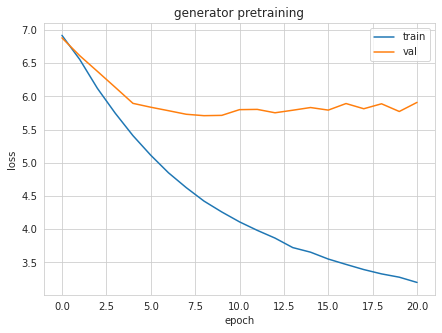

In [21]:
plt.figure(figsize=(7, 5))
plt.title('generator pretraining')
plt.plot(np.arange(0, len(epoch_losses)), epoch_losses,
         label='train')
plt.plot(np.arange(0, len(val_losses)), val_losses,
         label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [23]:
#save_path = 'saved_models/pretrained_seq2seq_gen.pth'
#torch.save(G.state_dict(), save_path)

In [22]:
for batch in train_dataloader:
    article = batch[0].to(device)
    highlight = batch[1].to(device)
    break
    
out = G(article, highlight, teacher_forcing_ratio=0.2)

### 5. discriminator pretraining

In [3]:
save_path = 'saved_models/pretrained_seq2seq_gen.pth'
G.load_state_dict(torch.load(save_path))

NameError: name 'G' is not defined

In [15]:
G.eval()

NameError: name 'G' is not defined

In [31]:
emb_dim = 256
hidden_dim = 256
vocab_size = 10000
padding_idx = 0
D = CNNDiscriminator3(embed_dim=emb_dim,
                     vocab_size=vocab_size,
                     num_classes=2,
                     filter_sizes=[2, 3],
                     num_filters=2,
                     padding_idx=padding_idx).to(device)

In [32]:
criterion = nn.BCELoss()
lr = 0.01
opt = torch.optim.Adam(D.parameters(), lr=lr)
n_epochs = 20

epoch_losses = []
val_losses = []
iter_num = -1
writer = SummaryWriter()

In [33]:
for epoch_idx in range(n_epochs):
    D.train()
    total_loss = 0.
    
    for batch_idx, data_input in tqdm(enumerate(train_dataloader)):
        article = data_input[0].to(device)
        highlight = data_input[1].to(device)
        generated_highlight = G(article, highlight, teacher_forcing_ratio=0.)
        generated_highlight = torch.argmax(F.softmax(generated_highlight, dim=2), dim=2).permute(1, 0)
        highlight = highlight.permute(1, 0)
        batch = torch.cat([generated_highlight, highlight], dim=0)
        targets = torch.tensor([0]*generated_highlight.size(0) + [1]*highlight.size(0)).to(device)
        opt.zero_grad()
        out = D(batch)
        loss = criterion(out.squeeze(1), targets.float())
        loss.backward()
        opt.step()
        total_loss += loss.data.item() * article.size(1) * 2
        iter_num += 1
        writer.add_scalar('Loss/train', loss.data.item(), iter_num)
    
    epoch_losses.append(total_loss / len(train_dataset) / 2)
    print(f'epoch {epoch_idx} train loss: {epoch_losses[-1]}')
    
    D.eval()
    total_loss = 0.
    for batch_idx, data_input in tqdm(enumerate(val_dataloader)):
        article = data_input[0].to(device)
        highlight = data_input[1].to(device)
        generated_highlight = G(article, highlight, teacher_forcing_ratio=0.)
        generated_highlight = torch.argmax(F.softmax(generated_highlight, dim=2), dim=2).permute(1, 0)
        highlight = highlight.permute(1, 0)
        batch = torch.cat([generated_highlight, highlight], dim=0)
        targets = torch.tensor([0]*generated_highlight.size(0) + [1]*highlight.size(0)).to(device)
        out = D(batch)
        loss = criterion(out.squeeze(1), targets.float())
        total_loss += loss.data.item() * article.size(1) * 2

    val_losses.append(total_loss / len(val_dataset) / 2)
    writer.add_scalar('Loss/val', val_losses[-1], iter_num)
    print(f'epoch {epoch_idx} val loss: {val_losses[-1]}')

539it [00:37, 14.25it/s]
2it [00:00, 14.50it/s]

epoch 0 train loss: 0.07664251564704444


231it [00:14, 15.64it/s]
2it [00:00, 14.75it/s]

epoch 0 val loss: 0.003788848715599257


539it [00:37, 14.22it/s]
2it [00:00, 15.50it/s]

epoch 1 train loss: 0.0396252931704643


231it [00:14, 15.58it/s]
2it [00:00, 13.08it/s]

epoch 1 val loss: 0.002563932663179496


539it [00:37, 14.22it/s]
2it [00:00, 15.41it/s]

epoch 2 train loss: 0.03428114900726752


231it [00:14, 15.61it/s]
2it [00:00, 14.25it/s]

epoch 2 val loss: 0.002433588463985444


539it [00:37, 14.23it/s]
2it [00:00, 14.90it/s]

epoch 3 train loss: 0.0334970743909184


231it [00:14, 15.57it/s]
2it [00:00, 14.68it/s]

epoch 3 val loss: 0.0023846047262741825


362it [00:25, 14.17it/s]


KeyboardInterrupt: 

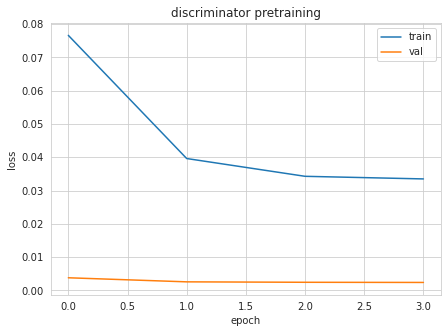

In [35]:
plt.figure(figsize=(7, 5))
plt.title('discriminator pretraining')
plt.plot(np.arange(0, len(epoch_losses)), epoch_losses,
         label='train')
plt.plot(np.arange(0, len(val_losses)), val_losses,
         label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [37]:
#save_path = 'saved_models/pretrained_dis.pth'
#torch.save(D.state_dict(), save_path)

### 6. adversarial training

In [33]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [34]:
vocab_size = 10000
INPUT_DIM = vocab_size
OUTPUT_DIM = vocab_size
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 256
N_LAYERS = 3
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM, N_LAYERS, ENC_DROPOUT)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

G = Seq2Seq(enc, dec, device).to(device)
save_path = 'saved_models/pretrained_seq2seq_gen.pth'
G.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [35]:
emb_dim = 256
hidden_dim = 256
vocab_size = 10000
padding_idx = 0
D = CNNDiscriminator3(embed_dim=emb_dim,
                     vocab_size=vocab_size,
                     num_classes=2,
                     filter_sizes=[2, 3],
                     num_filters=2,
                     padding_idx=padding_idx).to(device)
save_path = 'saved_models/pretrained_dis.pth'
D.load_state_dict(torch.load(save_path))

<All keys matched successfully>

In [36]:
n_epochs = 30

In [37]:
writer = SummaryWriter()

In [38]:
G.train()

Seq2Seq(
  (encoder): Encoder(
    (embedding): Embedding(10000, 256)
    (rnn): LSTM(256, 256, num_layers=3, dropout=0.1)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(10000, 256)
    (rnn): LSTM(256, 256, num_layers=3, dropout=0.1)
    (out): Linear(in_features=512, out_features=10000, bias=True)
    (w): Linear(in_features=256, out_features=256, bias=True)
    (attn_lin): Linear(in_features=512, out_features=512, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

In [ ]:
discriminator_optimizer = torch.optim.Adam(D.parameters(), lr=1e-4)
generator_optimizer = torch.optim.Adam(G.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss(ignore_index=0)
dis_criterion = nn.BCELoss()

G_losses = []
D_losses = []
iter_num = -1
G_ce_val_losses = []

for epoch_idx in range(n_epochs):
    total_G_loss = 0.
    total_D_loss = 0.
    G.train()
    D.train()
    for batch_idx, data_input in tqdm(enumerate(train_dataloader)):
        article = data_input[0].to(device)
        highlight = data_input[1].to(device)
        
        # Discriminator
        generated_highlight = G(article, highlight, teacher_forcing_ratio=0.)
        generated_highlight = torch.argmax(F.softmax(generated_highlight, dim=2), dim=2).permute(1, 0)
        batch = torch.cat([generated_highlight, highlight.permute(1, 0)], dim=0)
        targets = torch.tensor([0]*generated_highlight.size(0) + [1]*highlight.size(1)).to(device)
        discriminator_optimizer.zero_grad()
        generator_optimizer.zero_grad()
        out = D(batch)
        loss = dis_criterion(out.squeeze(1), targets.float())
        loss.backward()
        discriminator_optimizer.step()
        total_D_loss += loss.data.item() * highlight.size(1) * 2
        iter_num += 1
        writer.add_scalar('Loss/dis_adv_train', loss.data.item(), iter_num)
        
        # Generator
        generator_optimizer.zero_grad()
        discriminator_optimizer.zero_grad()
        # gen_out = G(article, highlight, teacher_forcing_ratio=0.)
        # generated_highlight = torch.argmax(F.softmax(gen_out, dim=2), dim=2).permute(1, 0)
        rewards = D(highlight.permute(1, 0)).squeeze(1)
        pg_loss = G.batch_pgloss(article, highlight, rewards)
        pg_loss.backward()
        generator_optimizer.step()
        writer.add_scalar('Loss/gen_pg_train', pg_loss.data.item(), iter_num)
        total_G_loss += pg_loss.data.item() * article.size(1)

    G_losses.append(total_G_loss / len(train_dataset))
    D_losses.append(total_D_loss / len(train_dataset) / 2)
    print(f'epoch {epoch_idx} G loss: {G_losses[-1]}')
    print(f'epoch {epoch_idx} D loss: {D_losses[-1]}')
    
    G.eval()
    total_loss = 0.
    for batch_idx, data_input in tqdm(enumerate(val_dataloader), position=0, leave=True):
        article = data_input[0].to(device)
        highlight = data_input[1].to(device)
        rewards = D(highlight.permute(1, 0)).squeeze(1)
        pg_loss = G.batch_pgloss(article, highlight, rewards)
        total_loss += pg_loss.data.item() * article.size(1)
    writer.add_scalar('Loss/gen_pg_val', total_loss / len(val_dataset), iter_num)
    
    total_loss = 0.
    for batch_idx, data_input in tqdm(enumerate(val_dataloader), position=0, leave=True):
        article = data_input[0].to(device)
        highlight = data_input[1].to(device)
        out = G(article, highlight, teacher_forcing_ratio=0.)
        loss = criterion(out.permute(1, 2, 0), highlight.permute(1, 0))
        total_loss += loss.data.item() * article.size(1)

    G_ce_val_losses.append(total_loss / len(val_dataset))
    print(f'epoch {epoch_idx} val loss: {G_ce_val_losses[-1]}')
    writer.add_scalar('Loss/gen_ce_val', G_ce_val_losses[-1], iter_num)
    ind = sps.randint(0, out.size(1)).rvs(size=1)[0]
    print(f'predicted: {tensor_to_text(out)[ind]}')
    print(f'truth: {tensor_to_text(highlight)[ind]}')

539it [01:56,  4.64it/s]
2it [00:00, 16.36it/s]

epoch 0 G loss: 61.6727937386011
epoch 0 D loss: 0.1096811717049447


231it [00:13, 16.56it/s]
231it [00:13, 17.14it/s]
0it [00:00, ?it/s]

epoch 0 val loss: 6.179974624778773
predicted: us woman lefts after sticks she was a fountain
truth: us woman severely injured after mistaking dynamite for candle


539it [01:56,  4.63it/s]
2it [00:00, 16.32it/s]

epoch 1 G loss: 46.069401897647516
epoch 1 D loss: 0.09996240845817583


231it [00:14, 16.49it/s]
231it [00:13, 17.00it/s]
0it [00:00, ?it/s]

epoch 1 val loss: 6.156999670842577
predicted: used to sell peanuts with brotherss lungi
truth: csk pacer lungi reveals he used to sell peanuts on roadside


539it [01:57,  4.60it/s]
2it [00:00, 15.97it/s]

epoch 2 G loss: 44.712041799476616
epoch 2 D loss: 0.10039087426562066


231it [00:14, 16.49it/s]
231it [00:13, 16.93it/s]
0it [00:00, ?it/s]

epoch 2 val loss: 6.161833875543771
predicted: cbi pasting with evidence s movement casesarushi talwars
truth: cbi planted witnesses in aarushi murder case allahabad hc


539it [01:56,  4.61it/s]
2it [00:00, 15.87it/s]

epoch 3 G loss: 43.90305819273272
epoch 3 D loss: 0.09818994845247435


231it [00:14, 16.47it/s]
231it [00:13, 17.12it/s]
0it [00:00, ?it/s]

epoch 3 val loss: 6.185020592472651
predicted: iit roorkee testing floating water water water water water
truth: iit roorkee tests device to generate electricity from river flow


539it [01:57,  4.60it/s]
2it [00:00, 16.44it/s]

epoch 4 G loss: 43.645165996130615
epoch 4 D loss: 0.09628048605446754


231it [00:14, 16.49it/s]
231it [00:13, 17.05it/s]
0it [00:00, ?it/s]

epoch 4 val loss: 6.212642153428542
predicted: used to sell peanuts with brotherss lungi
truth: csk pacer lungi reveals he used to sell peanuts on roadside


539it [01:57,  4.59it/s]
2it [00:00, 16.34it/s]

epoch 5 G loss: 43.58724126339513
epoch 5 D loss: 0.09546441142809654


231it [00:14, 16.48it/s]
231it [00:13, 17.04it/s]
0it [00:00, ?it/s]

epoch 5 val loss: 6.189366359842498
predicted: iit roorkee testing floating water water water water water
truth: iit roorkee tests device to generate electricity from river flow


539it [01:57,  4.60it/s]
2it [00:00, 16.31it/s]

epoch 6 G loss: 43.10098566283471
epoch 6 D loss: 0.09638921184406879


231it [00:13, 16.50it/s]
231it [00:13, 16.95it/s]
0it [00:00, ?it/s]

epoch 6 val loss: 6.158116029023696
predicted: world s smallest computer createsss
truth: how does the world s smallest computer work


539it [01:57,  4.60it/s]
2it [00:00, 16.40it/s]

epoch 7 G loss: 42.902998902324185
epoch 7 D loss: 0.09839860801687778


231it [00:14, 16.44it/s]
231it [00:13, 16.97it/s]
0it [00:00, ?it/s]

epoch 7 val loss: 6.18360246064108
predicted: my threat to kill my threat to owaisi on murder owaisi
truth: threat to my life claims aimim leader akbaruddin owaisi


539it [01:56,  4.61it/s]
2it [00:00, 15.89it/s]

epoch 8 G loss: 42.49524984326512
epoch 8 D loss: 0.09622350589271622


231it [00:13, 16.50it/s]
231it [00:13, 17.05it/s]
0it [00:00, ?it/s]

epoch 8 val loss: 6.221534188186802
predicted: aus australia australia a good word of game australia langer
truth: sledging is a fun part of the game aus coach justin langer


539it [01:57,  4.60it/s]
2it [00:00, 16.44it/s]

epoch 9 G loss: 42.135426407657846
epoch 9 D loss: 0.09629272132523523


231it [00:13, 16.53it/s]
231it [00:13, 17.05it/s]
0it [00:00, ?it/s]

epoch 9 val loss: 6.2067517435513135
predicted: 18 cpi m members held for life imprisonment in two years
truth: 18 cpi m men get life term for killing tmc workers in 2010


539it [01:56,  4.61it/s]
2it [00:00, 16.23it/s]

epoch 10 G loss: 41.92825721625528
epoch 10 D loss: 0.0969025917931024


231it [00:14, 16.39it/s]
231it [00:13, 17.01it/s]
0it [00:00, ?it/s]

epoch 10 val loss: 6.182829299111511
predicted: aus aus australia is good good a a a a
truth: sledging is a fun part of the game aus coach justin langer


539it [01:56,  4.61it/s]
2it [00:00, 16.30it/s]

epoch 11 G loss: 41.8895713877041
epoch 11 D loss: 0.09392872039449339


231it [00:14, 16.48it/s]
231it [00:13, 16.95it/s]
0it [00:00, ?it/s]

epoch 11 val loss: 6.2218152825528135
predicted: probe evidence of syrian prez assad s war un
truth: enough evidence to convict syrian prez of war crimes un


539it [01:57,  4.58it/s]
2it [00:00, 16.35it/s]

epoch 12 G loss: 41.680321648893454
epoch 12 D loss: 0.0960185723420358


231it [00:13, 16.50it/s]
231it [00:13, 17.01it/s]
0it [00:00, ?it/s]

epoch 12 val loss: 6.210086635657957
predicted: models co workings shot dead by florida
truth: 22 year old model shot dead inside her porsche in iraq


539it [01:57,  4.61it/s]
2it [00:00, 16.29it/s]

epoch 13 G loss: 41.51692865617599
epoch 13 D loss: 0.09562919054020295


231it [00:13, 16.52it/s]
231it [00:13, 17.06it/s]
0it [00:00, ?it/s]

epoch 13 val loss: 6.231154367580578
predicted: man awarded 4 8 crore after wildfireing marijuana
truth: us man awarded 4 8 crore after beer burns his organs


539it [01:57,  4.61it/s]
2it [00:00, 16.34it/s]

epoch 14 G loss: 41.0357845098161
epoch 14 D loss: 0.09596049041767431


231it [00:14, 16.42it/s]
231it [00:13, 16.97it/s]
0it [00:00, ?it/s]

epoch 14 val loss: 6.198367033098122
predicted: iit roorkee testing floating devices from water water river
truth: iit roorkee tests device to generate electricity from river flow


539it [01:57,  4.61it/s]
2it [00:00, 16.36it/s]

epoch 15 G loss: 41.06814658755348
epoch 15 D loss: 0.09561039259555586


231it [00:14, 16.40it/s]
231it [00:13, 16.92it/s]
0it [00:00, ?it/s]

epoch 15 val loss: 6.230391728078877
predicted: i would work with with dutt s biopic hirani on dutt biopic
truth: would like to work with ranbir kapoor again rajkumar hirani


539it [01:57,  4.60it/s]
2it [00:00, 16.35it/s]

epoch 16 G loss: 40.8503415062314
epoch 16 D loss: 0.09334016646692285


231it [00:14, 16.49it/s]
231it [00:13, 17.09it/s]
0it [00:00, ?it/s]

epoch 16 val loss: 6.228059393519418
predicted: trump reveals hackers were ignored over censorship
truth: social media giants are silencing millions of people trump


539it [01:57,  4.60it/s]
2it [00:00, 16.30it/s]

epoch 17 G loss: 40.51954257623936
epoch 17 D loss: 0.09472635195143823


231it [00:13, 16.52it/s]
231it [00:13, 17.13it/s]
0it [00:00, ?it/s]

epoch 17 val loss: 6.234075726445486
predicted: building of kartarpur corridor pm modi modi modi on guru day
truth: kartarpur corridor atonement for mistake made in 1947 pm modi


539it [01:57,  4.60it/s]
2it [00:00, 16.27it/s]

epoch 18 G loss: 40.55742091800278
epoch 18 D loss: 0.09438938090489024


231it [00:14, 16.41it/s]
231it [00:13, 16.92it/s]
0it [00:00, ?it/s]

epoch 18 val loss: 6.2395111941002295
predicted: delhi metro orders order to pay 60 crore in delhi
truth: delhi metro moves sc against 60 crore payment to rinfra arm


494it [01:47,  4.59it/s]